In [55]:
import os, sys, time, glob, random
# load yaml config
import yaml
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import numpy as np
from PIL import Image

from fit import lr_schedule, fit, TrainState, load_ckpt
from model.unetv3_light import UNetV3 as UNet


key = jax.random.PRNGKey(0)
cfg = yaml.safe_load(open("config.yaml"))
print(cfg)


# predict one image
def predict_one_image(state, img_path, cfg):
    img = jnp.array(Image.open(img_path).convert("RGB").resize((cfg["img_size"], cfg["img_size"])))
    # expand dims
    img = jnp.expand_dims(img, axis=0) / 255.
    pred = state.apply_fn({
        'params': state.params,
        'batch_stats': state.batch_stats,
    }, img, mutable=['batch_stats'], rngs={'dropout': key})
    return pred


{'img_size': 256, 'features': 16, 'batch_size': 8, 'lr': 0.005, 'epochs': 100, 'warmup': 5, 'ckpt': 'checkpoints/checkpoint_100', 'focal_loss': {'weight': 1.0}, 'dice_bce_loss': {'weight': 1.0}}


In [56]:

x = jnp.zeros((1, cfg["img_size"], cfg["img_size"], 3))

model = UNet(cfg["features"], training=False)
var = model.init(key, x)
params = var['params']
batch_stats = var['batch_stats']

state = TrainState.create(
    apply_fn=model.apply,
    params=params,
    batch_stats=batch_stats,
    tx=optax.inject_hyperparams(optax.nadam)(0),
)

state = load_ckpt(state, cfg["ckpt"])

# predict one image
img_path = '/Users/haoyu/Desktop/world license plate builder/output/image/*.png'
img_path = random.choice(glob.glob(img_path))
(pixs, ord_), _ = predict_one_image(state, img_path, cfg)

==      Loading ckpt from checkpoints/checkpoint_100      ==


In [57]:
pixs = jax.nn.sigmoid(pixs)
ord_ = jax.nn.sigmoid(ord_)
debug_ord = ord_

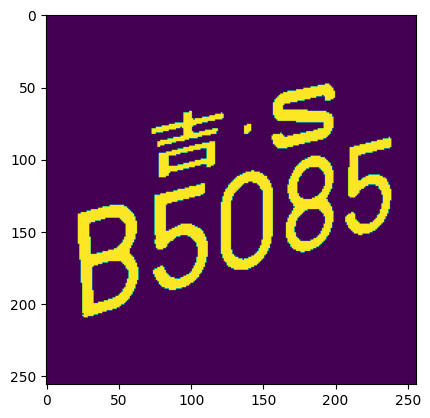

In [58]:
from matplotlib import pyplot as plt

pixs = jnp.where(pixs > 0.5, 1, 0)
plt.imshow(pixs[0])
plt.show()

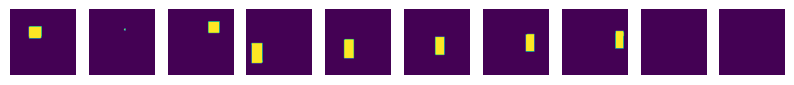

In [59]:
# show ord_
# ord_ = jnp.where(ord_[0] > 0.1, 1, 0)
# ord_ = jnp.argmax(ord_, axis=-1)
# plt.imshow(ord_)
# plt.show()

n = 10
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    tmp = debug_ord[0, :, :, i]
    tmp = jnp.where(tmp > 0.5, 1, 0)
    ax[i].imshow(tmp)
    ax[i].axis('off')
plt.show()


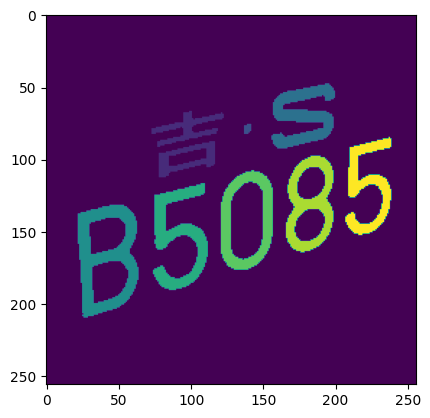

In [60]:
ord_ = jnp.where(ord_ > 0.5, ord_, 0)
ord_ += 1

res = np.zeros((debug_ord.shape[1], debug_ord.shape[2], debug_ord.shape[-1]))

for i in range(debug_ord.shape[-1]):
    res[:, :, i] = debug_ord[0, :, :, i] * np.squeeze(pixs[0]) * (i + 1)

res = np.max(res, axis=-1)
plt.imshow(res)
plt.show()